<a href="https://colab.research.google.com/github/fpichi/gca-rom/blob/main/notebook/10_stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
# Clone and import gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/fpichi/gca-rom.git
    sys.path.append('gca-rom')
else:
    sys.path.append('./..')

from gca_rom import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [4]:
import numpy as np
from itertools import product
from IPython.display import HTML

# Define PDE problem

In [5]:
problem_name, variable, mu_space, n_param, dim_pde, n_comp  = pde.problem(12)
argv = gui.hyperparameters_selection(problem_name, variable, n_param, n_comp)
HyperParams = network.HyperParams(argv)
HyperParams.rate = 70
HyperParams.__dict__

{'net_name': 'lid_driven_cavity',
 'variable': 'VX_VY',
 'scaling_type': 4,
 'scaler_number': 3,
 'scaler_name': 'standard',
 'skip': 1,
 'rate': 70,
 'sparse_method': 'L1_mean',
 'ffn': 200,
 'nodes': 50,
 'bottleneck_dim': 25,
 'lambda_map': 10.0,
 'in_channels': 2,
 'seed': 10,
 'tolerance': 1e-06,
 'learning_rate': 0.001,
 'act': <function torch._VariableFunctionsClass.tanh>,
 'layer_vec': [3, 50, 50, 50, 50, 25],
 'net_run': '_standard',
 'weight_decay': 1e-05,
 'max_epochs': 5000,
 'comp': 2,
 'hidden_channels': [2, 2],
 'miles': [],
 'gamma': 0.0001,
 'num_nodes': 0,
 'net_dir': './lid_driven_cavity/_standard/VX_VY_lid_driven_cavity_lmap10.0_btt25_seed10_lv4_hc2_nd50_ffn200_skip1_lr0.001_sc4_rate30/',
 'cross_validation': True}

# Initialize device and set reproducibility

In [6]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cuda


# Load dataset

In [7]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gca-rom/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable, dim_pde, n_comp)

time = mu_space[-1]
n_time = len(time)
n_snap = np.prod([len(mu_space[i]) for i in range(n_param)])
n_sim = int(n_snap/n_time)

n_snap2keep = 11
dataset, mu_space = preprocessing.shrink_dataset(dataset, mu_space, n_sim, n_snap2keep, n_comp)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

dataset, params, mu_space = preprocessing.delete_initial_condition(dataset, params, mu_space, n_comp, n_snap2keep)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams, param_sample=n_sim)

Number of nodes processed:  15681
Number of graphs processed:  250
Length of train dataset:  170
Length of test dataset:  80


# Define the architecture

In [8]:
model = network.Net(HyperParams)
model = model.to(device)
if 'google.colab' in str(get_ipython()):
  torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [9]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt'))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Loading saved network


# Evaluate the model

In [10]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 250/250 [00:02<00:00, 96.74it/s]


# Plot the results

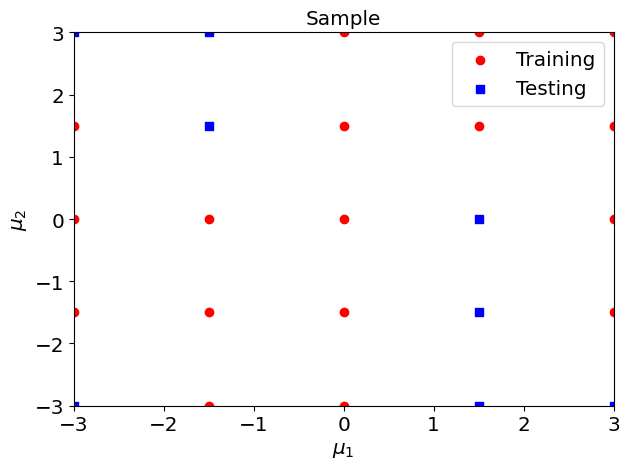

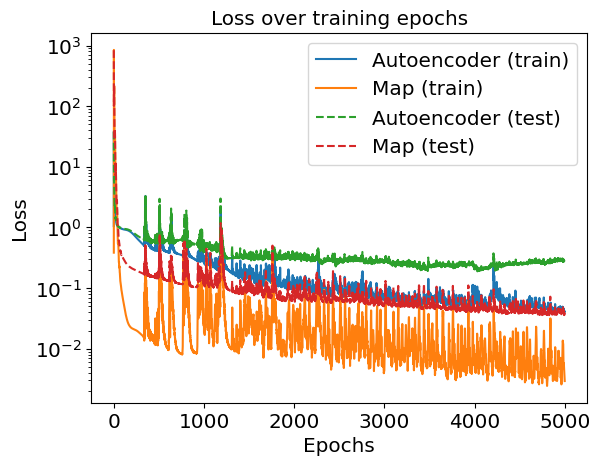

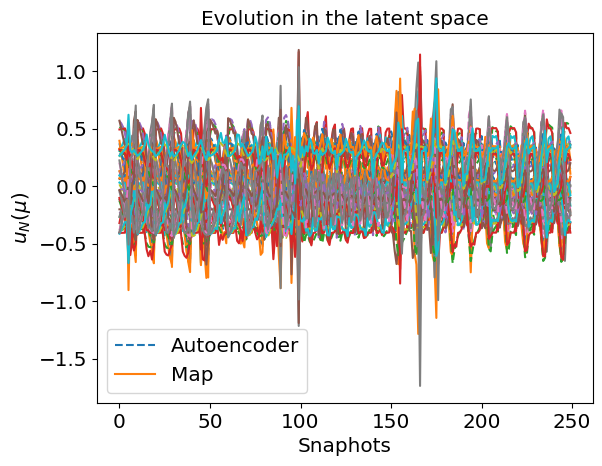

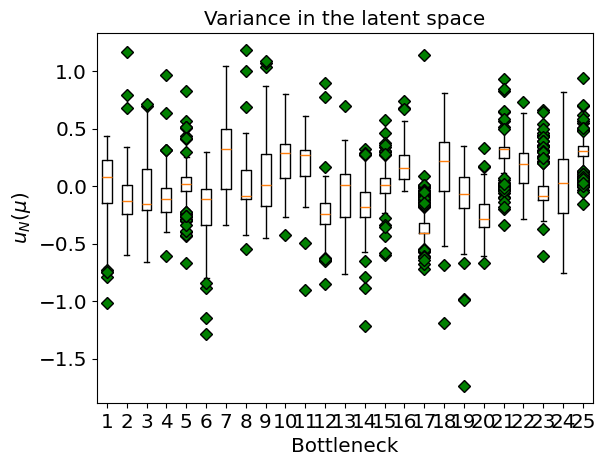

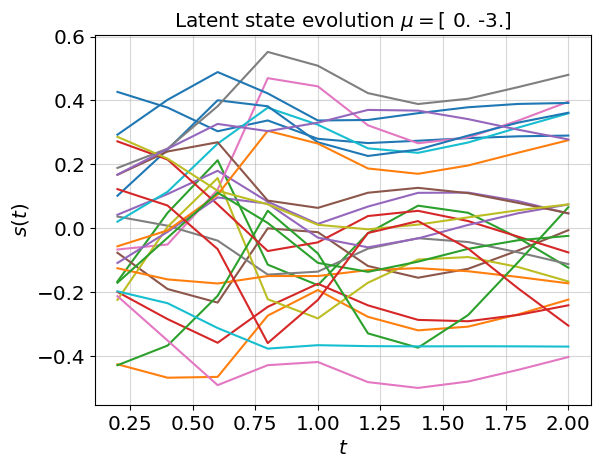

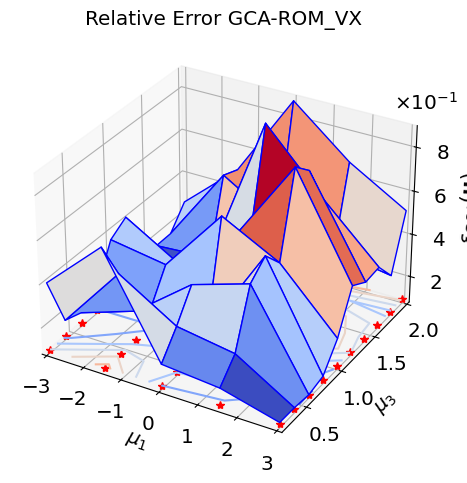

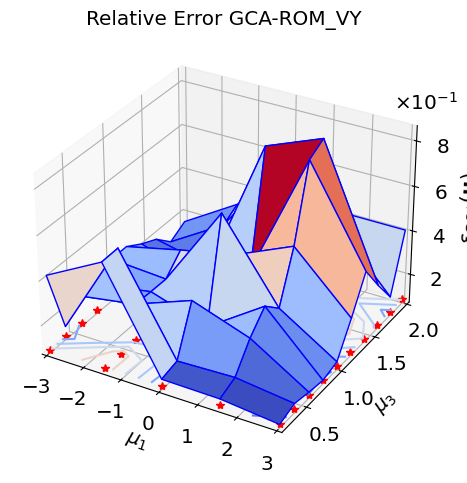

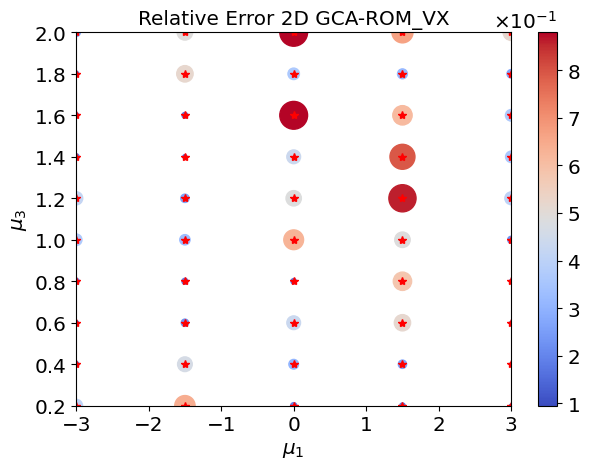

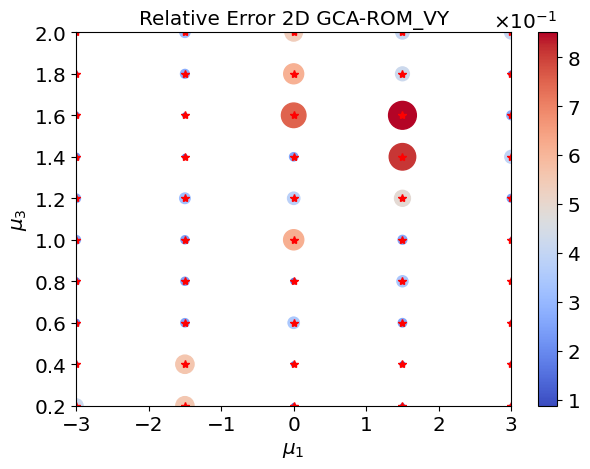

In [11]:
SAMPLE = 10
plotting.plot_sample(HyperParams, mu_space, params, train_trajectories, test_trajectories)
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
plotting.plot_latent_time(HyperParams, SAMPLE, latents_map, mu_space, params, n_sim)

results_VX = results[:, :, 0:1]
results_VY = results[:, :, 1:2]
VAR_all_VX = VAR_all[:, :, 0:1]
VAR_all_VY = VAR_all[:, :, 1:2]
plotting.plot_error(results_VX, VAR_all_VX, scaler_all[0], HyperParams, mu_space, params, train_trajectories, vars+"_VX")
plotting.plot_error(results_VY, VAR_all_VY, scaler_all[1], HyperParams, mu_space, params, train_trajectories, vars+"_VY")
plotting.plot_error_2d(results_VX, VAR_all_VX, scaler_all[0], HyperParams, mu_space, params, train_trajectories, vars+"_VX")
plotting.plot_error_2d(results_VY, VAR_all_VY, scaler_all[1], HyperParams, mu_space, params, train_trajectories, vars+"_VY")

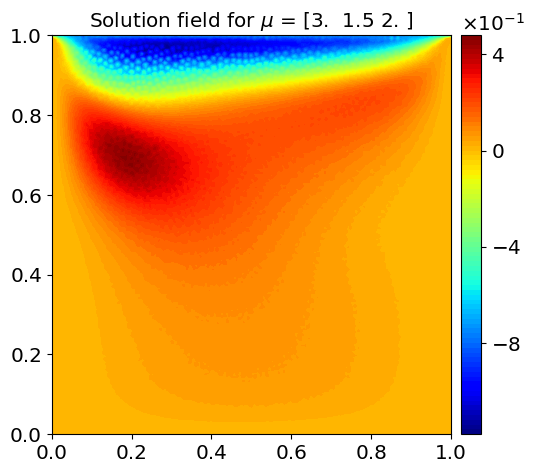

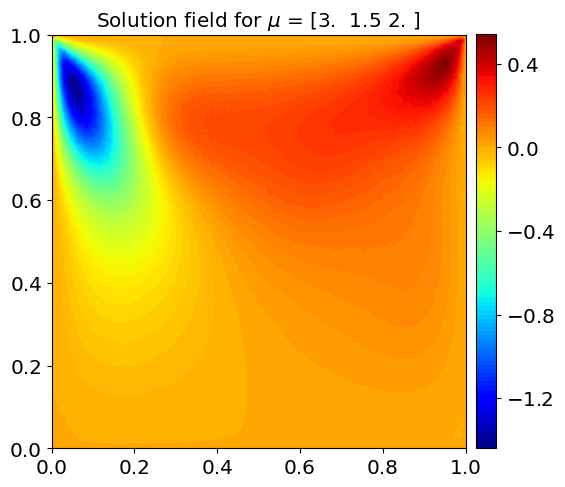

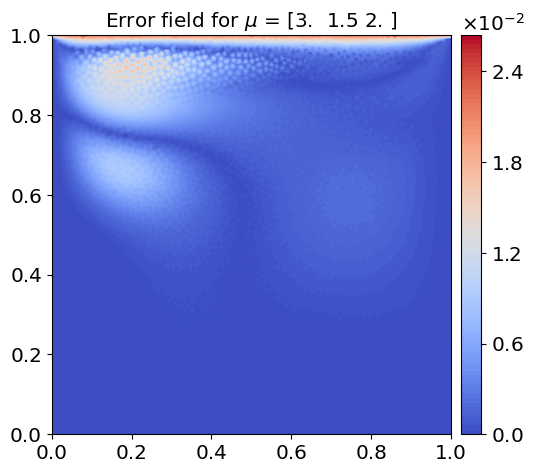

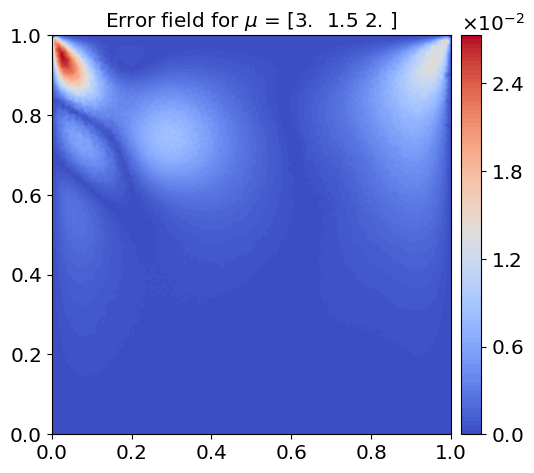

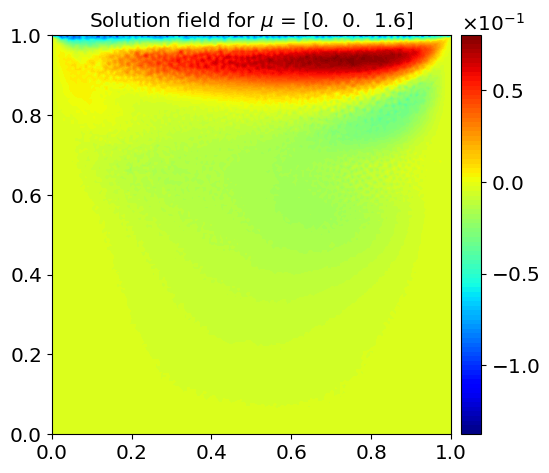

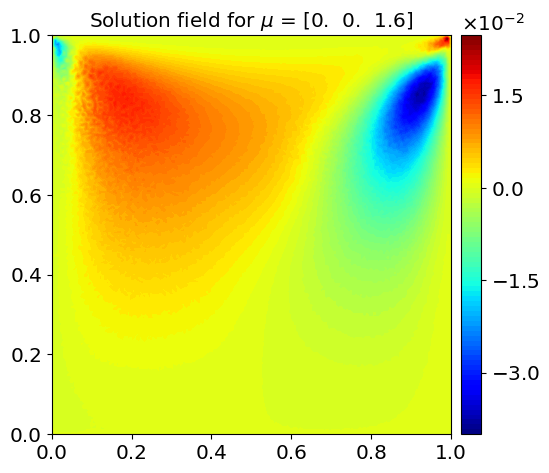

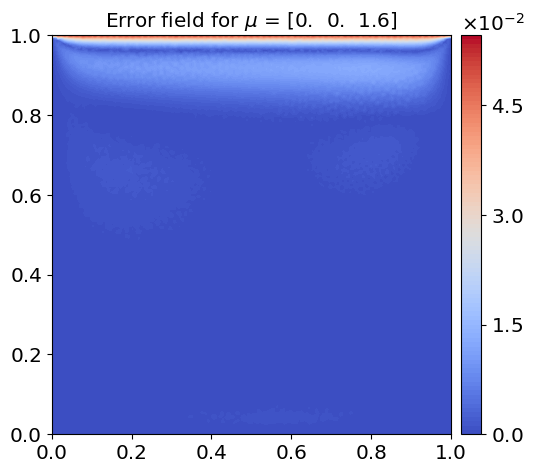

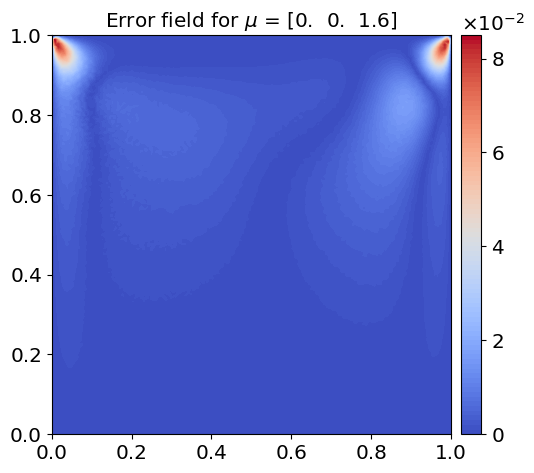

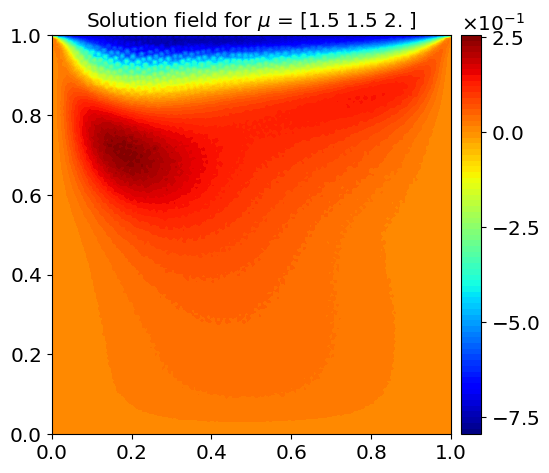

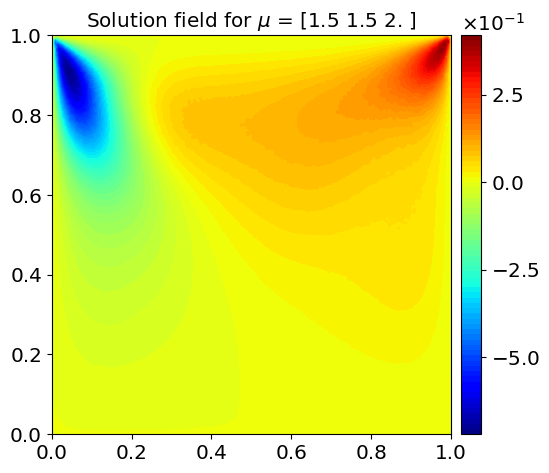

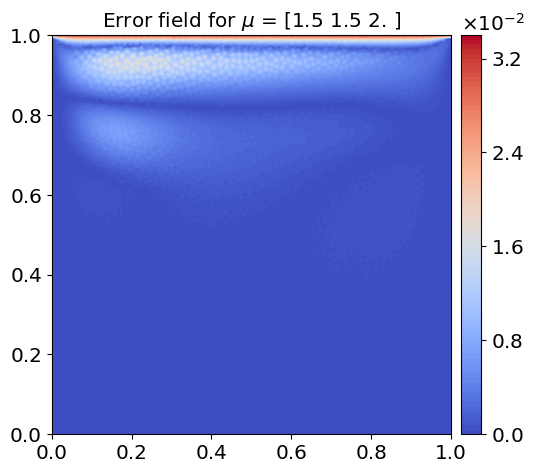

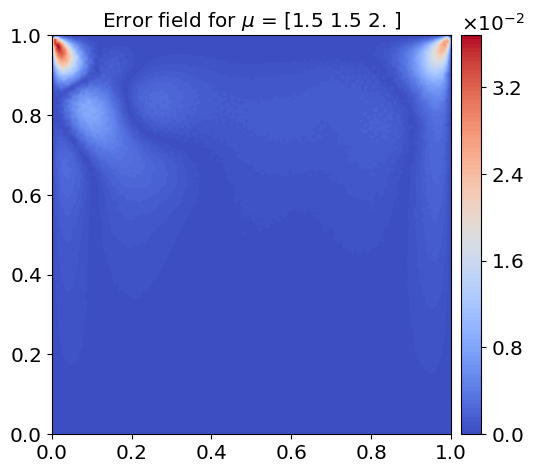

In [12]:
N = 3
snapshots = np.arange(params.shape[0]).tolist()
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results_VX, scaler_all[0], HyperParams, dataset, xyz, params, comp="_VX")
    plotting.plot_fields(SNAP, results_VY, scaler_all[1], HyperParams, dataset, xyz, params, comp="_VY")
    plotting.plot_error_fields(SNAP, results_VX, VAR_all_VX, scaler_all[0], HyperParams, dataset, xyz, params, comp="_VX")
    plotting.plot_error_fields(SNAP, results_VY, VAR_all_VY, scaler_all[1], HyperParams, dataset, xyz, params, comp="_VY")

In [13]:
anim = plotting.create_animation(SAMPLE, VAR_all_VX, scaler_all[0], HyperParams, dataset, xyz, params, n_sim)
HTML(anim.to_jshtml())

<Figure size 640x480 with 0 Axes>

# Print the errors on the testing set

100%|██████████| 80/80 [00:00<00:00, 101.68it/s]



Maximum absolute error for field GCA-ROM_VX =  25.26117284882058
Mean absolute error for field GCA-ROM_VX =  11.135563657060072
Minimum absolute error for field GCA-ROM_VX =  1.241467784600937

Maximum relative error for field GCA-ROM_VX =  1.2258715001284755
Mean relative error for field GCA-ROM_VX =  0.44046290433037416
Minimum relative error for field GCA-ROM_VX =  0.07395105492314032

Maximum absolute error for field GCA-ROM_VY =  11.242377129073702
Mean absolute error for field GCA-ROM_VY =  4.070098990662244
Minimum absolute error for field GCA-ROM_VY =  0.21183214536159847

Maximum relative error for field GCA-ROM_VY =  1.6717719009780003
Mean relative error for field GCA-ROM_VY =  0.37210621008676426
Minimum relative error for field GCA-ROM_VY =  0.07848769666060501


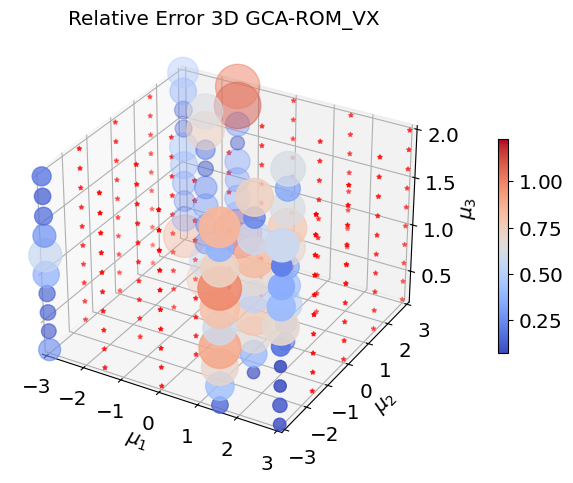

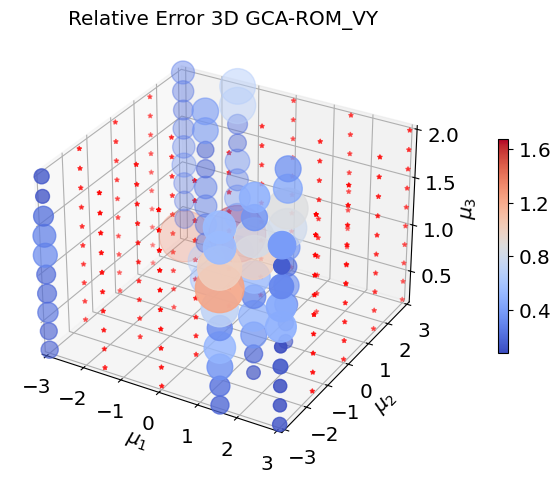

In [14]:
results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

results_test_VX = results_test[:, :, 0:1]
results_test_VY = results_test[:, :, 1:2]
VAR_test_VX = VAR_test[:, :, 0:1]
VAR_test_VY = VAR_test[:, :, 1:2]

error_abs_VX, norm_VX = error.compute_error(results_test_VX, VAR_test_VX, scaler_test[0], HyperParams)
error.print_error(error_abs_VX, norm_VX, vars+"_VX")
error.save_error(error_abs_VX, norm_VX, HyperParams, vars+"_VX")
error_abs_VY, norm_VY = error.compute_error(results_test_VY, VAR_test_VY, scaler_test[1], HyperParams)
error.print_error(error_abs_VY, norm_VY, vars+"_VY")
error.save_error(error_abs_VY, norm_VY, HyperParams, vars+"_VY")

plotting.plot_error_3d(results_test_VX, VAR_test_VX, scaler_test[0], HyperParams, mu_space, params, train_trajectories, vars+"_VX", test_trajectories=test_trajectories)
plotting.plot_error_3d(results_test_VY, VAR_test_VY, scaler_test[1], HyperParams, mu_space, params, train_trajectories, vars+"_VY", test_trajectories=test_trajectories)